In [ ]:
import pandas as pd 
import numpy as np 
import glob
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib import rcParams
import os

path = os.getenv("DATADIR")
data_dir = path+ "0_SUMS_Catalogs/"

# Sketchy files to remove from the analysis
sus_df = pd.read_csv(data_dir+'CompleteCatalog/MaskedSources/files_with_tracking_issues.csv')
# replace uvw1 with uw1
sus_df = sus_df.replace({'uvw1':'uw1','uvw2':'uw2','uvm2':'um2'})

# Step 2, remove sus files, combine into one dataframe
def get_df(filename,sus_df,uv_filter):
    df = pd.read_csv(filename)
    df = df[~df['filename'].isin(sus_df['files'])]
    df['uv_filter'] = uv_filter
    return df

smc_dfs = [get_df(f'{data_dir}CompleteCatalog/Step2/smc_{uvf}_step2.csv',sus_df[sus_df.galaxy=='smc'],uvf) for uvf in ['uw1','um2','uw2']]
smc = pd.concat(smc_dfs)
lmc_dfs = [get_df(f'{data_dir}CompleteCatalog/Step2/lmc_{uvf}_step2.csv',sus_df[sus_df.galaxy=='lmc'],uvf) for uvf in ['uw1','um2','uw2']]
lmc = pd.concat(lmc_dfs)

# Combine into one dataframe
df = pd.concat([smc,lmc]).reset_index(drop=True)

# Isolated Stars
iso = pd.read_csv('isolated_sources.csv')

In [19]:
# Reductions for binned by exposure time
df_exp = df.copy()
# Where closest is -99 or > 20
df_exp = df_exp[((df_exp.closest < 0) | (df_exp.closest > 20))]
# Faintness limit of 16.8
df_exp = df_exp[df_exp['MAG'] < 16.8]
# Mag Err less than 0.1
df_exp = df_exp[df_exp['MAG_ERR'] < 0.1]
# Reset Index 
df_exp = df_exp.reset_index(drop=True)
# Print Size
print(f'Reduced for Exposure Size: {df_exp.shape[0]}')

# Reductions for binned by magnitude
df_mag = df.copy()
# Where closest is -99 or > 20
df_mag = df_mag[((df_mag.closest < 0) | (df_mag.closest > 20))]
# Faintness limit of 16.8
df_mag = df_mag[df_mag['exposure'] > 200]
# Mag Err less than 0.1
df_mag = df_mag[df_mag['MAG_ERR'] < 0.12]
# Reset Index 
df_mag = df_mag.reset_index(drop=True)
print(f'Reduced for Mag Size: {df_mag.shape[0]}')

Reduced for Exposure Size: 1585
Reduced for Mag Size: 2269


In [20]:
# Set Exposure Time Bins
exp_lows = np.array([50,100,150,200,250,300,350,400,450,500])
exp_highs = np.array([100,150,200,250,300,350,400,450,500,800])
exp_bins = np.append(exp_lows,exp_highs[-1])

# Set Magnitude Bins
mag_lows = np.flip(np.arange(13,18,0.5) + 0.5)
mag_highs = np.flip(np.arange(13,18,0.5))
mag_highs[-1] = np.min(df_mag['MAG'])
mag_bins = np.append(mag_lows,mag_highs[-1])

def mad(values):
    """
    Returns the 
    MAD = median(abs(xi - median(xi)))
    """
    median = np.median(values)
    distances = values - median
    mad = np.median(abs(distances))
    return mad

def check_bin(bin,bin_name,low,high):
    if bin.shape[0] < 1:
        print(f'Bin contains {bin.shape[0]} for {bin_name}: {low} - {high}, Median: {np.median(bin["RESID_FRAC"]):.2f} MAD: {mad(bin["RESID_FRAC"]):.2f}')

median_rf_exps = {}
median_me_exps = {}
mad_rf_exps = {}
median_rf_mags = {}
median_me_mags = {}
mad_rf_mags = {}

for uvf in ['uw1','um2','uw2']:
    median_rf_exp, mad_rf_exp = [],[]
    median_rf_mag, mad_rf_mag = [],[]
    median_me_exp, median_me_mag = [],[]
    for exp_low, exp_high, mag_low, mag_high in zip(exp_lows,exp_highs,mag_lows,mag_highs):
        # Get Bins for Exposure Time
        bin_df_exp = df_exp[(df_exp['exposure'] > exp_low) & (df_exp['exposure'] < exp_high) & (df_exp['uv_filter'] == uvf)]
        # Check if bin is empty
        check_bin(bin_df_exp,f'{uvf} Exposure Time',exp_low,exp_high)
        # Get median for each bin
        median_rf_exp.append(bin_df_exp['RESID_FRAC'].median())
        # Get MAD for each bin
        mad_rf_exp.append(mad(bin_df_exp['RESID_FRAC']))
        # Get Mag Err for each bin
        median_me_exp.append(bin_df_exp['MAG_ERR'].median())
        
        # Get Bins for Magnitude
        bin_df_mag = df_mag[(df_mag['MAG'] < mag_low) & (df_mag['MAG'] > mag_high) & (df_mag['uv_filter'] == uvf)]
        # Check if bin is empty
        check_bin(bin_df_mag,f'{uvf} Magnitude',mag_low,mag_high)
        # Get median for each bin
        median_rf_mag.append(bin_df_mag['RESID_FRAC'].median())
        # Get MAD for each bin
        mad_rf_mag.append(mad(bin_df_mag['RESID_FRAC']))
        # Get Mag Err for each bin
        median_me_mag.append(bin_df_mag['MAG_ERR'].median())

    median_rf_exps[uvf] = median_rf_exp
    mad_rf_exps[uvf] = mad_rf_exp
    median_me_exps[uvf] = median_me_exp
    median_rf_mags[uvf] = median_rf_mag
    mad_rf_mags[uvf] = mad_rf_mag
    median_me_mags[uvf] = median_me_mag

# Calculate the average of the bins and the error
mag_bin_avg = (mag_lows+mag_highs)/2
mag_bin_x_err = np.abs(mag_highs - mag_bin_avg)
exp_bin_avg = (exp_lows+exp_highs)/2
exp_bin_x_err = exp_highs - exp_bin_avg

/var/folders/v7/3cz8p5d553b7s1dcymxc7m1hdpkh95/T/ipykernel_47606/2697686054.py:157: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/v7/3cz8p5d553b7s1dcymxc7m1hdpkh95/T/ipykernel_47606/2697686054.py:157: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


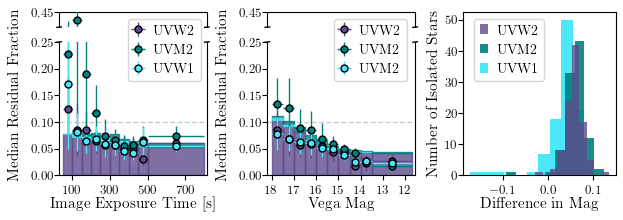

In [45]:
plt.style.use(path+'bl.mplstyle')

def color_variant(hex_color, brightness_offset=1):
    """ takes a color like #87c95f and produces a lighter or darker variant """
    if brightness_offset < 20: 
        return hex_color
    rgb_hex = [hex_color[x:x+2] for x in [1, 3, 5]]
    new_rgb_int = [int(hex_value, 16) + brightness_offset for hex_value in rgb_hex]
    new_rgb_int = [min([255, max([0, i])]) for i in new_rgb_int] # make sure new values are between 0 and 255
    # hex() produces "0x88", we want just "88"
    return "#" + "".join([hex(i)[2:] for i in new_rgb_int])

size_low = 3.5
size_high = 0.4
width = 1
fig_w = 7.12663097223 +0.5
fig_h = fig_w / 3 - 0.5
labelfontsize = 11
scattersize = 5
labelpad = 0

f = plt.figure(constrained_layout=True, figsize=(fig_w, fig_h))

# Use gridspec to set the size of the subplots for the first two 
gs = f.add_gridspec(2, 3,  width_ratios=(width,width,width), height_ratios=(size_high, size_low), wspace=0.41,left=0.25, right=0.99, bottom=0.1, top=0.9)
# Create the first two split plots
ax_t = f.add_subplot(gs[0, 0])
ax_b = f.add_subplot(gs[1, 0])

bx_t = f.add_subplot(gs[0, 1])
bx_b = f.add_subplot(gs[1, 1])

# Add third subplot that is full height
cx = f.add_subplot(gs[:, 2])
# move cx to the left, [left, bottom, width, height] 
cx.set_position([0.78, 0.1, 0.2,0.8])


# Remove the spines from first two plots
[ax.spines['top'].set_visible(False) for ax in [ax_b,bx_b]]
[ax.spines['bottom'].set_visible(False) for ax in [ax_t,bx_t]]
[ax.set_xticks([]) for ax in [ax_t,bx_t]];

# Set plot limits 
[ax.set_ylim(0.36,0.45) for ax in [ax_t,bx_t]]
[ax.set_ylim(0.0,0.25) for ax in [ax_b,bx_b]]
[bx.invert_xaxis() for bx in [bx_t,bx_b]]

# first plot xticks
[ax.set_xlim(30,815) for ax in [ax_b,ax_t]]
p1_xticks = np.arange(100,800+100,200)
ax_b.set_xticks(p1_xticks)
ax_b.set_xticklabels(p1_xticks) 
# second plot xticks
[bx.set_xlim(18.2,11.55) for bx in [bx_b,bx_t]]
p2_xticks = np.arange(18,12-1,-1)
bx_b.set_xticks(p2_xticks)
bx_b.set_xticklabels(p2_xticks)

# Set ticks
[ax.set_yticks([0.45]) for ax in [ax_t,bx_t]] # ******

# Grey dashed line
[ax.axhline(0.1,linestyle='--',color='k',alpha=0.2) for ax in [ax_b,bx_b]]

# Diagonal lines
d = .015  # how big to make the diagonal lines in axes coordinates
d2 = d*size_high/size_low # Get ratio right for lower bit
kwargs = [dict(transform=ax.transAxes, color='k', clip_on=False) for ax in [ax_t,bx_t,ax_b,bx_b]] # arguments to pass to plot
[ax.plot((-d, +d), (-d, +d), **kwargs[i]) for i, ax in enumerate([ax_t,bx_t])]        # top-left diagonal
[ax.plot((1 - d, 1 + d), (-d, +d), **kwargs[i]) for i, ax in enumerate([ax_t,bx_t])]  # top-right diagonal
[ax.plot((-d, +d), (1 - d2, 1 + d2), **kwargs[2+i]) for i, ax in enumerate([ax_b,bx_b])]        # bottom-left diagonal
[ax.plot((1 - d, 1 + d), (1 - d2, 1 + d2), **kwargs[2+i]) for i, ax in enumerate([ax_b,bx_b])]  # bottom-right diagonal

# Set plot labels 
y_lp=5
lp=0.5
#ax_b.set_ylabel(' ',fontsize=labelfontsize,labelpad=y_lp)
#bx_b.set_ylabel('Median Residual Fraction',fontsize=labelfontsize,labelpad=y_lp)
ax_b.set_xlabel('Image Exposure Time [s]',labelpad=lp)
bx_b.set_xlabel('Vega Mag',labelpad=lp)
cx.set_xlabel('Difference in Mag',labelpad=lp)
cx.set_ylabel('Number of Isolated Stars',labelpad=y_lp-2)

# Make text on axis instead of using y label
ax_b.text(-0.3, 0.6, 'Median Residual Fraction',  ha='center', va='center', transform=ax_b.transAxes,rotation=90,fontsize=labelfontsize)
bx_b.text(-0.3, 0.6, 'Median Residual Fraction', ha='center', va='center', transform=bx_b.transAxes,rotation=90,fontsize=labelfontsize)
# Move plot over to make room for text


# Set tick label size
[ax.tick_params(axis='both', which='major') for ax in [ax_t,bx_t,ax_b,bx_b,cx]]

# Set colors
cols = ['#5f4b8b','#008080','#4be8f9'] 

# First Plot 
[ax.errorbar(exp_bin_avg,median_rf_exps['uw2'],yerr=mad_rf_exps['uw2'],xerr=exp_bin_x_err,fmt='o',color=cols[0],ms=scattersize,elinewidth=1,label='UVW2',markeredgecolor='k',zorder=10) for ax in [ax_b,ax_t]]
[ax.errorbar(exp_bin_avg,median_rf_exps['um2'],yerr=mad_rf_exps['um2'],xerr=exp_bin_x_err,fmt='o',color=cols[1],ms=scattersize,elinewidth=1,label='UVM2',markeredgecolor='k',zorder=10) for ax in [ax_b,ax_t]]
[ax.errorbar(exp_bin_avg,median_rf_exps['uw1'],yerr=mad_rf_exps['uw1'],xerr=exp_bin_x_err,fmt='o',color=cols[2],ms=scattersize,elinewidth=1,label='UVM2',markeredgecolor='k',zorder=10) for ax in [ax_b,ax_t]]

# Second Plot 
[bx.errorbar(mag_bin_avg,median_rf_mags['uw2'],yerr=mad_rf_mags['uw2'],xerr=mag_bin_x_err,fmt='o',color=cols[0],ms=scattersize,elinewidth=1,label='UVW2',markeredgecolor='k',zorder=10) for bx in [bx_b,bx_t]]
[bx.errorbar(mag_bin_avg,median_rf_mags['um2'],yerr=mad_rf_mags['um2'],xerr=mag_bin_x_err,fmt='o',color=cols[1],ms=scattersize,elinewidth=1,label='UVM2',markeredgecolor='k',zorder=10) for bx in [bx_b,bx_t]]
[bx.errorbar(mag_bin_avg,median_rf_mags['uw1'],yerr=mad_rf_mags['uw1'],xerr=mag_bin_x_err,fmt='o',color=cols[2],ms=scattersize,elinewidth=1,label='UVW1',markeredgecolor='k',zorder=10) for bx in [bx_b,bx_t]]

# Shading for first and second plot 
zorders = [3,1,2]
alpha = .8
b = 0
lightened_colors = [color_variant(cols[i],b) for i in range(3)]
colors = lightened_colors

for low, high, e_um2, e_uw2, e_uw1 in zip(exp_lows,exp_highs,median_me_exps['um2'],median_me_exps['uw2'],median_me_exps['uw1']):
    ax_b.fill_between([low,high],0,e_uw2,color=colors[0],alpha=alpha)
    if e_um2 > e_uw2 :
        ax_b.fill_between([low,high],e_uw2,e_um2,color=colors[1],alpha=alpha)
    if e_uw1 > e_uw2 and np.abs(e_um2 - e_uw1) > 0.001:
        ax_b.fill_between([low,high],e_uw2,e_uw1,color=colors[2],alpha=alpha)


for low, high, m_um2, m_uw2, m_uw1 in zip(mag_lows,mag_highs,median_me_mags['um2'],median_me_mags['uw2'],median_me_mags['uw1']):
    bx_b.fill_between([high,low],0,m_uw2,color=colors[0],alpha=alpha)
    if m_um2 > m_uw2 :
        bx_b.fill_between([high,low],m_uw2,m_um2,color=colors[1],alpha=alpha)
    if m_uw1 > m_uw2 and np.abs(m_um2 - m_uw1) > 0.001:
        bx_b.fill_between([high,low],m_uw2,m_uw1,color=colors[2],alpha=alpha)
# Third plot
uvw2_mag_diff = iso[iso.uvfilter == 'uvw2']['MAG'] - iso[iso.uvfilter == 'uvw2']['uvots_mag']
uvm2_mag_diff = iso[iso.uvfilter == 'uvm2']['MAG'] - iso[iso.uvfilter == 'uvm2']['uvots_mag']
uvw1_mag_diff = iso[iso.uvfilter == 'uvw1']['MAG'] - iso[iso.uvfilter == 'uvw1']['uvots_mag']

alpha = 1
bins = 10
cx.hist(uvw2_mag_diff,color=cols[0],alpha=alpha-0.2,label='UVW2',bins=bins,zorder=3);
cx.hist(uvm2_mag_diff,color=cols[1],alpha=alpha-0.1,label='UVM2',bins=bins,zorder=2);
cx.hist(uvw1_mag_diff,color=cols[2],alpha=alpha,label='UVW1',bins=bins,zorder=1);

# Add legend for middle plot but move to right without disturbing the y axis 
handles, labels = bx_b.get_legend_handles_labels()

f.legend(handles, labels, loc='upper right',bbox_to_anchor=(0.445, 0.9),handletextpad=0.8,handlelength=0.6)
handles, labels = ax_b.get_legend_handles_labels()
f.legend(handles, labels, loc='upper right',bbox_to_anchor=(0.715,0.9),handletextpad=0.8,handlelength=0.6)

# Add legend for third plot
# Create new legend handles but use the colors from the existing ones
handles, labels = cx.get_legend_handles_labels()
new_handles = [Line2D([0.1,0.1], [0.1,0.1], c=color,lw=3,alpha=0.9) for color in cols]
cx.legend(loc='upper right',bbox_to_anchor=(0.575, 1),handlelength=0.6,handletextpad=0.6)

[ax.tick_params(axis='y', which='major', pad=0.5) for ax in [ax_b,ax_t]]
[ax.tick_params(axis='y', which='major', pad=0.5) for ax in [bx_b,bx_t]]
cx.tick_params(axis='y', which='major', pad=0.5) 
# Save fig
# Set facecolor to white
plt.tight_layout()
plt.savefig('residuals.pdf',bbox_inches='tight',dpi=1000)
